*JSC270, Winter 2020 - Prof. Chevalier*

# <center>  Laboratory 2.1 - "A Look at Movies Shot in Toronto"  </center>
## <center> Lab assignment </center>

### <center> Date: January 15, 12:00 - 14:00, BA3175 <br><br> Due Date: January 20, 12:00pm (noon) 
<center>  This assignment is a group assignment. <br>Groups will be randomly assigned at the beginning of the lab.</center>


***

We are interested in exploring what makes movies shot in Toronto successeful. This lab assignment builds on the L2.0. pre-lab assignment, and will use data scraped from the Wikipedia page on [Movies Shot in Toronto](https://en.wikipedia.org/wiki/List_of_films_shot_in_Toronto), and data pulled from the [Open Movie Database (omdb)](https://www.omdb.org/) via its [API](http://www.omdbapi.com/). 

***

<div style="background-color: #f7f7f7; padding:10px;">
    
<h3> Objectives </h3>

<ul>
    <li> more pandas manipulations </li>
    <li> data cleaning and wrangling: identify sources of errors, and apply strategy to address anomalies</li>
    <li> explore relatioships between data dimensions </li>
    <li> data analysis and plotting </li>
</ul>

<h3> Instructions </h3>

<ul>
    <li> Make a copy of this notebook: <a href="https://classroom.github.com/g/66LVrJ2z">https://classroom.github.com/g/66LVrJ2z</a> </li>
    <li> Answer the questions in the cells that indicate where your answers should be placed.  </li>
     <li> Make sure that you explain your solutions when asked and comment your code for readability. </li>
    <li> Commit and push changes to the Github classroom repository that has been provided (more details below).</li>
    <li> Submit a pdf report to Quercus (more details below).</li>
 </ul>
    


</div>

***

<br>

# I. Data Cleaning and Wrangling

The objective of this step is to understand and address problems when combining data from multiple sources.

**Question 1.** Copy your code from the L2.0. pre-lab assignment to create a dataframe containing the detailed information pulled from [OMDB](http://www.omdbapi.com/), for the movies as found on the [Wikipedia page of Movies Shot in Toronto](https://en.wikipedia.org/wiki/List_of_films_shot_in_Toronto).

> We will first use the code from the prelab to get a cleaned table of movies listed on the Wikipedia page.
The raw table is displayed in the prelab, so here we are showing directly the table after cleaning.

In [1]:
import pandas as pd
import omdb
import requests
from urllib import parse

In [2]:
url = "https://en.wikipedia.org/wiki/List_of_films_shot_in_Toronto"
df = pd.read_html(url, header=0)
movies = df[1]

# remove rows that are transformed from subsection header (e.g. A[edit])
# remove rows that are about TV series instead movies
movies = movies[~(movies.Notes.astype(str).str.contains("edit|TV"))]
# drop the Notes column
movies = movies.drop(['Notes'], axis=1)

print('There are', len(movies), 'movies on the Wikipedia page in total.')
movies

There are 270 movies on the Wikipedia page in total.


,Title,Year
1,.45,"2005, 2006"
3,Adventures in Babysitting,1987
4,The Adventures of Pluto Nash,2002
5,Against the Ropes,2004
6,Angel Eyes,2001
...,...,...
304,Waiting for Summer,2012
306,Welcome to Mooseport,2004
307,Where the Truth Lies,2005
308,Wrong Turn,2003


In [3]:
# The following code is copied from the prelab:

API_KEY = 'd82688ee'
omdb.set_default('apikey', API_KEY)

movie_list = []
for moviename in movies.Title:
    result = omdb.title(moviename, timeout = 5)
    if ('response' in result and result['response'] == 'True'):
        movie_list.append(result)

In [4]:
# combine the dictionaries into a single dataframe
movies_omdb = pd.DataFrame(movie_list)
print('By querying the imdb API with the movie titles, we get information of', len(movie_list), 'movies.')
print('Thus at least', len(movies) - len(movie_list), 'movies are missing.')

By querying the imdb API with the movie titles, we get information of 256 movies.
Thus at least 14 movies are missing.


**Question 2.** We want all of the movies listed in the Wikipedia page to be represented in our final dataframe. Explain the problems faced when querying the omdb API using the data extracted from Wikipedia. Devise a strategy to address these problems. Explain your strategy, and discuss its limitations, if any. 
<br>(Do not implement your solution yet).

**Problems:**

When querying the omdb API using the data extracted from Wikipedia, the main problems can be divided into the following two categories.

Category 1: these problems would cause the query to fail
- Problem 1: Some movies listed in the Wikipedia page are named differently in the omdb database. For example, in the omdb, 'American Psycho 2' is named as 'Amerian Psycho II'; 'Cube 2: Hypercube' is named as 'Cube$^2$: Hypercube'.
- Problem 2: Unexpected characters are included in the movie title. For example, 'The Shape of Water[1]' includes an extra '[1]' which links to the reference section on the Wikipedia page.
- Problem 3: Some movies are associated with a different year in the omdb dataset when compared to the Wikipedia page (the years should typically only differ by 1 if the records are referring to the same movie). The query would fail if we also include year as a filter.
- Problem 4: Some movies are missing in the omdb database.

Category 2: these problems would not fail the query but would lead to incorrect results
- Problem 5: Multiple movies might have the same title but different years. If we only use the movie title when querying the omdb API, we could get a different movie. For example, we are interested in 'Robocop' filmed in 1994, but we would get 'Robocop' in 1987 if we query using only its title.
- Problem 6: Movies and TV series might share the same title (ex. 'The F Word'). If we do not specify the type to be 'movie' and use only the title, we could get a TV series instead.
- Problem 7: Although we have removed all rows that are noted 'TV series', there might still be some non-movie data left. Thus we would not find out this problem if we do not specify the type to be 'movie'.
- Problem 8: Some movies are missing in the omdb database but a movie with the same name exists and is returned as the result.

**Strategy:**
1. Query the omdb API again with both the title and the year and with the type filter set to 'movie'. Doing so will address Problem 5, 6 and 7.
2. Separate out the unsuccessful queries into cases by querying the API again with just the title: if it is successful, we know that this corresponds to Problem 3 or 8 (case 1); otherwise, it may be related to Problem 1, 2 or 7 (case 2).
3. In case 1, compare the two years. If the two numbers only differ by 1 and/or we are certain that they refer to the same movie, modify the year to be the one recorded in omdb; otherwise, exclude that movie.
4. In case 2, print out the movie title and year. To solve Problem 1, manually search in the API to see if it is recorded using a different title. To solve Problem 2, manually clean the title. As for Problem 7, its type can be verified by searching online and we should exclude the non-movie entries.
5. If after the above steps there are still some failed queries, then it is very likely that it is Problem 4 (i.e. the movies are not in the omdb database) and thus we have to exclude those movies from the final dataframe.

**Limitations:**
1. Step 3 requires us to check if the record in omdb refers to the same movie despite having a different year. This might be difficult and might require using our own judgement.
2. Step 4 requires us to manually modify the title. This is only doable if the number of unsuccessful queries is small.
3. We cannot solve Problem 4, i.e., when the database does not have the movie we want.

**Question 3.**  Write python code to address the problems identified in Question 2, using your proposed strategy. Use this code to create a new dataframe, that contains all of the individual movies listed on the Wikipedia page, and their information pulled from omdb.

> We first implement Step 1 (i.e. query the omdb API again with both the title and the year and with the type filter set to 'movie') and Step 2 (i.e. separate out the unsuccessful queries into cases by querying the API again with just the title) with the following code segment. We will use three lists to separately store the successful ones, the ones with a different year, and the ones with a title that does not exist in the database.

In [5]:
# dfs
correct_result = []
diff_year = []
name_not_exist = []

for title, year in zip(movies.Title, movies.Year):
    # use quote() to take care of the blank spaces in title and year
    t = parse.quote(title)
    y = parse.quote(year)
    # concatenate the filters with the base url
    omdb_url = 'http://www.omdbapi.com/?apikey=d82688ee'
    
    # first use all of the title, year, and type filters
    result = requests.get(f'{omdb_url}&t={t}&y={y}&type=movie', timeout = 5) 
    result = result.json()
    if ('Response' in result and result['Response'] == 'True'):
        # successful query, i.e. returned the correct movie
        correct_result.append(result)
        continue
        
    # next check if exists a movie with the same title but in different year
    result = requests.get(f'{omdb_url}&t={t}&type=movie', timeout = 5)  
    result = result.json()

    if ('Response' in result and result['Response'] == 'True'):
        diff_year.append((title, year, result['Year']))
        continue
        
    # getting here means the movie title is not in the omdb database
    name_not_exist.append((title, year))
    

In [6]:
print(len(correct_result), 'successful queries')

240 successful queries


> We found out that there are 30 unsuccessful queries in total. We will now implement Step 3 and Step 4. 

> Step 3. For those with a different year recorded in omdb, compare the two years and modify the year to be the one recorded in omdb if the two numbers only differ by 1 and/or we are certain that they refer to the same movie. 

In [7]:
print(len(diff_year), 'movies have a different year recorded in omdb:')
diff_year

14 movies have a different year recorded in omdb:


[('Aurora Borealis', '2006', '2005'),
 ('Capote', '2004', '2005'),
 ('A Change of Mind', '1967', '2016'),
 ('Circle of Two', '1980', '1981'),
 ('Clubland', '2007', '1999'),
 ('A Cool, Dry Place', '1999', '1998'),
 ('The Heist', '2001', '1989'),
 ('Hello Mary Lou: Prom Night II', '1987', '2015'),
 ('A Home at the End of the World', '1990', '2004'),
 ('In Too Deep', '1998', '1999'),
 ('Knockaround Guys', '2002', '2001'),
 ('A Map of the World', '2000', '1999'),
 ('Nurse 3D', '2012', '2013'),
 ("Sharpay's Fabulous Adventure", '2010', '2011')]

In [8]:
# modify those where the two years only differ by 1:
for (t, y1, y2) in diff_year:
    if (abs(int(y1) - int(y2)) <= 1):
        movies.Year[movies.Title == t] = y2

# the rest are not in omdb: ('A Change of Mind', 1967), ('Clubland', '2007'),
# ('The Heist', '2001'), ('Hello Mary Lou: Prom Night II', '1987')
# ('A Home at the End of the World', '1990')

In [9]:
# modify those where the two years only differ by 1:
movies.Year[movies.Title == 'Aurora Borealis'] = '2005'
movies.Year[movies.Title == 'Capote'] = '2005'
movies.Year[movies.Title == 'Circle of Two'] = '1981'
movies.Year[movies.Title == 'A Cool, Dry Place'] = '1998'
movies.Year[movies.Title == 'In Too Deep'] = '1999'
movies.Year[movies.Title == 'Knockaround Guys'] = '2001'
movies.Year[movies.Title == 'A Map of the World'] = '1999'
movies.Year[movies.Title == 'Nurse 3D'] = '2013'
movies.Year[movies.Title == "Sharpay's Fabulous Adventure"] = '2011'

# the rest are not in omdb: ('A Change of Mind', 1967), ('Clubland', '2007'),
# ('The Heist', '2001'), ('Hello Mary Lou: Prom Night II', '1987')
# ('A Home at the End of the World', '1990')

> Step 4. For those with a title not in omdb, print out the movie title and year. Either manually clean the title or search in the API to see if it is recorded using a different title. (In case that it is not a movie, we do not need to do anything.)

In [10]:
print(len(name_not_exist), 'movies not found in omdb:')
name_not_exist

16 movies not found in omdb:


[('American Psycho 2', '2002'),
 ('Central Park Drifter aka Graveyard Shift', '1987'),
 ('Cube 2: Hypercube', '2002'),
 ('Death Weekend', '1976'),
 ('Graveyard Shiftaka Central Park Drifter', '1987'),
 ('Hollywoodlandaka Truth, Justice and the American Way', '2006'),
 ('Kal Ho Na Ho', '2003'),
 ('Murder in the Hamptons', '2005'),
 ('Robocop: The Series', '1994'),
 ('Saw 3D', '2010'),
 ('Sesame Street Presents Follow That Bird', '1985'),
 ('The Shape of Water[1]', '2017'),
 ('Superstar: Dare To Dream', '1998'),
 ('Teenage Fairytale Dropouts', '2012'),
 ('Three Men and a Baby', '1987'),
 ('Truth, Justice and the American Wayaka Hollywoodland', '2006')]

In [11]:
# 'Teenage Fairytale Dropouts' and 'Three Men and a Baby' are 'series', so we do not need to include them

# 'Truth, Justice and the American Wayaka Hollywoodland' and 'Hollywoodlandaka Truth, Justice and the American Way'
# 'Graveyard Shiftaka Central Park Drifter' and 'Central Park Drifter aka Graveyard Shift'
# are two pairs of duplicates; remove one of the two in each pair:
movies = movies[movies.Title != 'Truth, Justice and the American Wayaka Hollywoodland']
movies = movies[movies.Title != 'Graveyard Shiftaka Central Park Drifter']

# modify the title of the rest to the version in the omdb database:
movies = movies.replace({'Title': {'American Psycho 2':'American Psycho II',
                                  'Central Park Drifter aka Graveyard Shift':'Graveyard Shift',
                                  'Cube 2: Hypercube':'Cube²: Hypercube',
                                  'Death Weekend':'The House by The Lake',
                                  'Hollywoodlandaka Truth, Justice and the American Way':'Hollywoodland',
                                  'Kal Ho Na Ho':'Kal Ho Naa Ho',
                                  'Murder in the Hamptons':'Million Dollar Murder',
                                  'Robocop: The Series':'Robocop',
                                  'Saw 3D':'Saw: The Final Chapter',
                                  'Sesame Street Presents Follow That Bird':'Follow That Bird',
                                  'The Shape of Water[1]':'The Shape of Water',
                                  'Superstar: Dare To Dream':'Dare To Dream'}})

> Finally, we can query the API again and print the results.

In [12]:
movie_list = []
failed = []

for title, year in zip(movies.Title, movies.Year):
    # use quote() to take care of the blank spaces in title and year
    t = parse.quote(title)
    y = parse.quote(year)
    # concatenate the filters with the base url
    omdb_url = 'http://www.omdbapi.com/?apikey=d82688ee'
    
    # first use all of the title, year, and type filters
    result = requests.get(f'{omdb_url}&t={t}&y={y}&type=movie', timeout = 5) 
    result = result.json()

    if ('Response' in result and result['Response'] == 'True'):
        movie_list.append(result)
    else:
        failed.append((title, year))

In [13]:
print(len(failed), 'are either not a movie or not in the omdb database - they are excluded from the dataframe.')
failed

7 are either not a movie or not in the omdb database - they are excluded from the dataframe.


[('A Change of Mind', '1967'),
 ('Clubland', '2007'),
 ('The Heist', '2001'),
 ('Hello Mary Lou: Prom Night II', '1987'),
 ('A Home at the End of the World', '1990'),
 ('Teenage Fairytale Dropouts', '2012'),
 ('Three Men and a Baby', '1987')]

In [14]:
# combine the dictionaries into a single dataframe
movies_df = pd.DataFrame(movie_list)

# reorder the column to make sure that the title is the leftmost column
movies_df = movies_df.reindex(columns=
                                  (['Title'] + list([a for a in movies_df.columns if a != 'Title']) ))

In [15]:
movies_df

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,.45,2006,R,30 Nov 2006,101 min,"Crime, Drama, Thriller",Gary Lennon,Gary Lennon,"Milla Jovovich, Angus Macfadyen, Stephen Dorff...","A story of how obsession, addiction and abuse ...",...,N/A,5.6,"7,825",tt0259822,movie,24 Apr 2007,N/A,Media Talent Group,N/A,True
1,Adventures in Babysitting,1987,PG-13,03 Jul 1987,102 min,"Adventure, Comedy, Crime, Romance",Chris Columbus,David Simkins,"Elisabeth Shue, Maia Brewton, Keith Coogan, An...",A babysitter must battle her way through the b...,...,45,6.9,"35,183",tt0092513,movie,18 Jan 2000,N/A,Touchstone Pictures,N/A,True
2,The Adventures of Pluto Nash,2002,PG-13,16 Aug 2002,95 min,"Comedy, Action, Sci-Fi",Ron Underwood,Neil Cuthbert,"Eddie Murphy, Randy Quaid, Rosario Dawson, Joe...","In the future, a man struggles to keep his lun...",...,12,3.8,"23,497",tt0180052,movie,24 Dec 2002,"$4,366,829",Warner Bros.,N/A,True
3,Against the Ropes,2004,PG-13,20 Feb 2004,111 min,"Biography, Drama, Romance, Sport",Charles S. Dutton,"Jackie Kallen (life), Cheryl Edwards","Meg Ryan, Omar Epps, Charles S. Dutton, Tony S...",A fictional story inspired by North America's ...,...,36,5.3,"6,550",tt0312329,movie,13 Jul 2004,"$5,696,752",Paramount Pictures,N/A,True
4,Angel Eyes,2001,R,18 May 2001,102 min,"Drama, Romance",Luis Mandoki,Gerald Di Pego,"Jennifer Lopez, Jim Caviezel, Jeremy Sisto, Te...",A mysterious man is drawn to a feisty female p...,...,39,5.6,"21,632",tt0225071,movie,26 Oct 2004,N/A,Bandai,N/A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Waiting for Summer,2012,N/A,30 Mar 2012,88 min,Drama,Senthil Vinu,Senthil Vinu,"Virginia Leigh, Caleb Verzyden, David Amito, S...",This romantic drama tells the story of a young...,...,N/A,7.8,10,tt2388811,movie,N/A,N/A,N/A,N/A,True
257,Welcome to Mooseport,2004,PG-13,20 Feb 2004,110 min,"Comedy, Romance",Donald Petrie,"Doug Richardson (story), Tom Schulman (screenp...","Gene Hackman, Ray Romano, Marcia Gay Harden, M...",A US president who has retired after two terms...,...,33,5.2,"11,831",tt0361925,movie,25 May 2004,"$14,244,145",20th Century Fox,N/A,True
258,Where the Truth Lies,2005,R,07 Oct 2005,107 min,"Crime, Drama, Mystery, Thriller",Atom Egoyan,"Atom Egoyan (screenplay), Rupert Holmes (novel)","Kevin Bacon, Colin Firth, Alison Lohman, David...","Karen O'Connor, a young journalist known for h...",...,47,6.5,"16,553",tt0373450,movie,28 Aug 2007,N/A,N/A,N/A,True
259,Wrong Turn,2003,R,30 May 2003,84 min,Horror,Rob Schmidt,Alan B. McElroy,"Desmond Harrington, Eliza Dushku, Emmanuelle C...",Six people find themselves trapped in the wood...,...,32,6.1,"103,742",tt0295700,movie,14 Oct 2003,"$15,176,515",20th Century Fox Distribution,N/A,True


In [16]:
print('Our final dataframe has', len(movies_df), 'movies.')

Our final dataframe has 261 movies.


> Recall that we had 270 rows from the Wikipedia page. There are 2 pairs of rows that refer to the same movie; 2 rows referring to a 'series' instead of a 'movie'; and 5 rows referring to a movie not in the omdb database. Thus, we have 261 rows in the final database.

In Part II, we will be using 'BoxOffice', 'imdbRating' and 'Metascore' as numeric values and so we will first convert all these data values.

In [17]:
import numpy as np
# remove extra characters
movies_df['BoxOffice'] = movies_df['BoxOffice'].replace('\$|,', '', regex=True)

# convert these to numeric
for col in ['BoxOffice', 'Metascore', 'imdbRating']:
    movies_df[col] = movies_df[col].replace('^N/A$', np.nan, regex = True)
    movies_df[col] = pd.to_numeric(movies_df[col], errors = 'coerce')

movies_df

,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,...,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response
0,.45,2006,R,30 Nov 2006,101 min,"Crime, Drama, Thriller",Gary Lennon,Gary Lennon,"Milla Jovovich, Angus Macfadyen, Stephen Dorff...","A story of how obsession, addiction and abuse ...",...,NaN,5.6,"7,825",tt0259822,movie,24 Apr 2007,NaN,Media Talent Group,N/A,True
1,Adventures in Babysitting,1987,PG-13,03 Jul 1987,102 min,"Adventure, Comedy, Crime, Romance",Chris Columbus,David Simkins,"Elisabeth Shue, Maia Brewton, Keith Coogan, An...",A babysitter must battle her way through the b...,...,45.0,6.9,"35,183",tt0092513,movie,18 Jan 2000,NaN,Touchstone Pictures,N/A,True
2,The Adventures of Pluto Nash,2002,PG-13,16 Aug 2002,95 min,"Comedy, Action, Sci-Fi",Ron Underwood,Neil Cuthbert,"Eddie Murphy, Randy Quaid, Rosario Dawson, Joe...","In the future, a man struggles to keep his lun...",...,12.0,3.8,"23,497",tt0180052,movie,24 Dec 2002,4366829.0,Warner Bros.,N/A,True
3,Against the Ropes,2004,PG-13,20 Feb 2004,111 min,"Biography, Drama, Romance, Sport",Charles S. Dutton,"Jackie Kallen (life), Cheryl Edwards","Meg Ryan, Omar Epps, Charles S. Dutton, Tony S...",A fictional story inspired by North America's ...,...,36.0,5.3,"6,550",tt0312329,movie,13 Jul 2004,5696752.0,Paramount Pictures,N/A,True
4,Angel Eyes,2001,R,18 May 2001,102 min,"Drama, Romance",Luis Mandoki,Gerald Di Pego,"Jennifer Lopez, Jim Caviezel, Jeremy Sisto, Te...",A mysterious man is drawn to a feisty female p...,...,39.0,5.6,"21,632",tt0225071,movie,26 Oct 2004,NaN,Bandai,N/A,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,Waiting for Summer,2012,N/A,30 Mar 2012,88 min,Drama,Senthil Vinu,Senthil Vinu,"Virginia Leigh, Caleb Verzyden, David Amito, S...",This romantic drama tells the story of a young...,...,NaN,7.8,10,tt2388811,movie,N/A,NaN,N/A,N/A,True
257,Welcome to Mooseport,2004,PG-13,20 Feb 2004,110 min,"Comedy, Romance",Donald Petrie,"Doug Richardson (story), Tom Schulman (screenp...","Gene Hackman, Ray Romano, Marcia Gay Harden, M...",A US president who has retired after two terms...,...,33.0,5.2,"11,831",tt0361925,movie,25 May 2004,14244145.0,20th Century Fox,N/A,True
258,Where the Truth Lies,2005,R,07 Oct 2005,107 min,"Crime, Drama, Mystery, Thriller",Atom Egoyan,"Atom Egoyan (screenplay), Rupert Holmes (novel)","Kevin Bacon, Colin Firth, Alison Lohman, David...","Karen O'Connor, a young journalist known for h...",...,47.0,6.5,"16,553",tt0373450,movie,28 Aug 2007,NaN,N/A,N/A,True
259,Wrong Turn,2003,R,30 May 2003,84 min,Horror,Rob Schmidt,Alan B. McElroy,"Desmond Harrington, Eliza Dushku, Emmanuelle C...",Six people find themselves trapped in the wood...,...,32.0,6.1,"103,742",tt0295700,movie,14 Oct 2003,15176515.0,20th Century Fox Distribution,N/A,True


<br>

# II. Data Analysis

Answer the following questions. For each question: Explain your methods and use appropriate plots to present your results; Discuss your results (i.e. what are the implications of your findings); Explain and justify data wrangling operations that you perform in order to make the data amenable to analyses, if any.

**Question 1.** Explore the relationship between the `imdb_ratings` and the `metascore` for these movies. 

Both imdb_rating and metascore are quantitative variables, so we will use a scatter plot to visualize the relationship, and calculate the Pearson correlation coefficient between the variables.
First we will do some data wrangling to convert the type of the two columns to numeric, and remove invalid rows.

In [18]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Remove rows with NaN in metascore or imdb_rating
movies_cleaned = movies_df.dropna(subset = ['Metascore', 'imdbRating'])

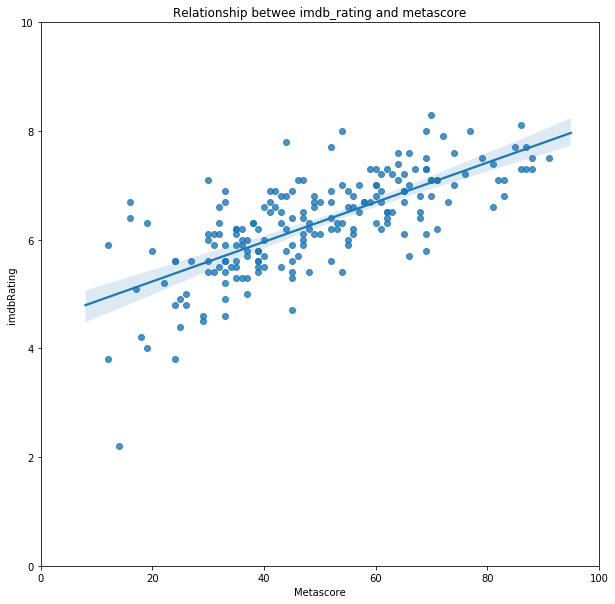

In [20]:
plt.figure(figsize=(10,10))
graph = sns.regplot(x='Metascore', y='imdbRating', data=movies_cleaned)
# graph.set(ylim=(0, 10), xlim=(0,100))

plt.xlim(0,100)
plt.ylim(0,10)
plt.title("Relationship betwee imdb_rating and metascore")
plt.show()

Most points are distributed relatively close to the best fit line, which suggests a positive correlation between the imdb_rating and the metascore. Next we will calculate the Pearson correlation coefficient of the relationship.

In [21]:
from scipy import stats

x = movies_cleaned['Metascore']
y = movies_cleaned['imdbRating']

pearson_coef, p_value = stats.pearsonr(x, y)
print("Pearson correlation coefficient: ", pearson_coef, "and p-value: ", p_value)

Pearson correlation coefficient:  0.7196834233262255 and p-value:  3.315512121143327e-33


The Pearson correlation coefficient is approximately 0.72, which shows a positive correlation. If a movie has a high imdb_rating, it will tend to have a high metascore as well. The p-value is very small, so that the correlation is statistically significant.  

This positive correlation is what we would expect, since imdb_rating and metascore are two different criteria to measure the quality of the movie. If a movie is considered to be good, then it should get a high score in both ratings. However, the correlation coefficient is not very close to 1. One reason behind that is the imdb_rating is calculated based on votes from individual users, while the metascore is an weighted average on critics' reviews. It is reasonable that the general public's opinion and the professionals' opinion differ on some movies. It would be interesting to investigate which movies have similar ratings from the public and from critics, and which movies get very different ratings in further analysis.  

We also notice that most movies on this scatter plot have an imdb rating from 4-8, while the metascore varies more. This can be shown from the standard deviation of the two variables:

In [22]:
print("The standard deviation of metascore is: ", np.std(x), "on a 100-point scale")
print("The standard deviation of idmb rating is: ", np.std(y), "on a 10-point scale")

The standard deviation of metascore is:  17.871652833467866 on a 100-point scale
The standard deviation of idmb rating is:  0.904516307205127 on a 10-point scale


This difference arises because of different ways to collect scores and calculate the average. Metacritic, the website that generates metascore, assigns weights to reviews, and normalizes the resulting scores to prevent scores from clumping together.
On contrast, when users rate movies on imdb, they assign stars on a five-star scale. This limits the values that raw scores can take. Although imdb also calculates a weighted average, it does not mention any normalization.

**Question 2.** Explore the relationship between the `production` company, and the `boxoffice` for these movies.

**Data Wrangling**

In [23]:
movies_df[['Title', 'Production', 'BoxOffice']].head(10)

,Title,Production,BoxOffice
0,.45,Media Talent Group,NaN
1,Adventures in Babysitting,Touchstone Pictures,NaN
2,The Adventures of Pluto Nash,Warner Bros.,4366829.0
3,Against the Ropes,Paramount Pictures,5696752.0
4,Angel Eyes,Bandai,NaN
5,American Pie Presents: Beta House,Universal Studios Home Video,NaN
6,American Pie Presents: The Naked Mile,Universal Studios Home Video,NaN
7,American Psycho,Lions Gate Films,NaN
8,American Psycho II: All American Girl,LionsGate Entertainment,NaN
9,Ararat,Miramax Films,NaN


There are three problems in the data when we explore the relationship between the production company and the boxoffice:

- Problem 1: N/A values in production and box office should be removed.
- Problem 2: Inconsistent naming in production. The same company's name are written in many variations, for example, 'Warner Bros.', 'Warner Bros. Pictures', and 'Warner Brothers'. 
- Problem 3: Some movies record the name of the subsidiary company, while others use the name of the parent company. For example, we find that 'The Man(2005)' and 'It(2017)' are both produced by New Line Cinema, but the production of 'The Man' is written as 'New Line Cinema', and the production of 'It' is 'Warner Bros.'(The parent company of New Line Cinema).

Problem 3 is difficult to address, because in some cases it is hard to decide whether we should replace subsidiary companies with their parent companies in our dataset. In addition, some companies have undergone several merges or acquisitions, and the parent corporation has a complicated structure with multiple divisions, so it is not clear which parent company we should use to replace. To avoid diving too deep in the movie business industry, we decide to collect lists of subsidiaries from the website, and match the companies in our dataset with companies on the list. 

First, we remove the N/A values.

In [24]:
m_na = movies_df.loc[movies_df.BoxOffice.isnull()]
print("There are", len(m_na), "movies whose box office is not recorded.")
print("They are produced by", len(m_na.groupby(['Production']).groups.keys()), "different companies.")

There are 141 movies whose box office is not recorded.
They are produced by 75 different companies.


In [25]:
# Remove rows that has N/A in Production and BoxOffice
m_cleaned2 = movies_df.loc[~movies_df.Production.isnull()].copy()
m_cleaned2 = m_cleaned2.loc[~m_cleaned2.BoxOffice.isnull()]
print("There are", len(m_cleaned2), "movies whose box office is recorded.")

There are 120 movies whose box office is recorded.


In [26]:
print("There are", len(m_cleaned2.groupby(['Production']).groups.keys()), "companies in the raw data:")
print(m_cleaned2.groupby(['Production']).groups.keys())

There are 45 companies in the raw data:
dict_keys(['20th Century Fox', '20th Century Fox Distribution', 'A24 and DIRECTV', 'Buena Vista', 'Buena Vista Pictures', 'Columbia Pictures', 'Columbia Tristar Pictures', 'Destination Films', 'Dreamworks Distribution LLC', 'Element Pictures', 'Fine Line Features', 'Focus Features', 'Fox Atomic', 'Fox Searchlight Pictures', 'IFC Films', 'Lions Gate Films', 'Lionsgate', 'Lionsgate Films', 'MGM', 'MGM/UA', 'Magnolia Pictures', 'Millenium Entertainment', 'Miramax Films', 'New Line Cinema', 'Orion Pictures', 'Overture', 'Overture Films', 'Paramount Pictures', 'Picturehouse', 'Screen Gems', 'Sony Pictures', 'Sony Pictures Classics', 'Sony Pictures Releasing', 'Sony Pictures/Screen Gems', 'Summit Entertainment', 'ThinkFilm', 'Touchstone Pictures', 'UTV Communications', 'United Artists Films', 'Universal Pictures', 'Universal Studios', 'Warner Bros.', 'Warner Bros. Pictures', 'Warner Brothers', 'Yash Raj Films'])


It is obvious that some different names refer to the same company. We will manually clean those cases.

In [27]:
m_cleaned2 = m_cleaned2.replace({'Production': {'20th Century Fox Distribution': '20th Century Fox',
                                                'Buena Vista Pictures': 'Buena Vista',
                                                'Columbia Tristar Pictures': 'Columbia Pictures',
                                                'Lions Gate Films': 'Lionsgate',
                                                'Lionsgate Films': 'Lionsgate',
                                                'MGM/UA': 'MGM',
                                                'Overture Films': 'Overture',
                                                'Sony Pictures/Screen Gems': 'Screen Gems',
                                                'Universal Studios': 'Universal Pictures',
                                                'Warner Bros. Pictures': 'Warner Bros.',
                                                'Warner Brothers': 'Warner Bros.'}})
production = m_cleaned2.groupby(['Production']).groups.keys()

In [28]:
print("There are", len(production), "companies after fixing inconsistent name of the same company.")

There are 34 companies after fixing inconsistent name of the same company.


Then we identify the parent companies, get the lists of their subsidiary companies from website, and check if any of the companies above is listed as a subsidiary. We make a copy of the current dataframe, where the names of subsidiary companies are replaced by their parent companies.

In [29]:
fox_web = requests.get("https://www.sec.gov/Archives/edgar/data/1308161/000119312507187791/dex21.htm")
fox = fox_web.text

lions_web = \
requests.get("https://www.sec.gov/Archives/edgar/data/929351/000092935112000030/exhibit211-subsidiariesoft.htm")
lions = lions_web.text

sony_web = requests.get("https://www.sonypictures.com/corp/subsidiaries.html")
sony = sony_web.text

mgm_web = requests.get("https://en.wikipedia.org/wiki/Category:Metro-Goldwyn-Mayer_subsidiaries")
mgm = mgm_web.text

wb_web = requests.get("https://en.wikipedia.org/wiki/List_of_assets_owned_by_WarnerMedia")
wb = wb_web.text

In [30]:
subsidiary = {'20th Century Fox': [], 'Lionsgate': [], 'MGM': [], 'Sony Pictures': [], 'Warner Bros.': []}
# Make a copy so that the original dataframe is not affected
m_nosub = m_cleaned2.copy()

for key in production:
    if key in fox and key != '20th Century Fox':
        subsidiary['20th Century Fox'].append(key)
        m_nosub.loc[m_nosub.Production == key, 'Production'] = '20th Century Fox'
        continue
        
    if key in lions and key != 'Lionsgate':
        subsidiary['Lionsgate'].append(key)
        m_nosub.loc[m_nosub.Production == key, 'Production'] = 'Lionsgate'
        continue
        
    if key in mgm and key != 'MGM':
        subsidiary['MGM'].append(key)
        m_nosub.loc[m_nosub.Production == key, 'Production'] = 'Sony Pictures' # MGM is a subsidiary of Sony
        continue

    if key in sony and key != 'Sony Pictures':
        subsidiary['Sony Pictures'].append(key)
        m_nosub.loc[m_nosub.Production == key, 'Production'] = 'Sony Pictures'
        continue
    
    if key in wb and key != 'Warner Bros.':
        subsidiary['Warner Bros.'].append(key)
        m_nosub.loc[m_nosub.Production == key, 'Production'] = 'Warner Bros.'
        
subsidiary

{'20th Century Fox': ['Fox Atomic', 'Fox Searchlight Pictures'],
 'Lionsgate': ['Summit Entertainment'],
 'MGM': ['Orion Pictures'],
 'Sony Pictures': ['Columbia Pictures',
  'MGM',
  'Screen Gems',
  'Sony Pictures Classics',
  'Sony Pictures Releasing'],
 'Warner Bros.': ['Fine Line Features',
  'New Line Cinema',
  'Picturehouse',
  'Sony Pictures']}

In [31]:
print("There are", len(m_nosub.groupby(['Production']).groups.keys()), \
      "companies after replacing subsidiary companies.")

There are 22 companies after replacing subsidiary companies.


**Analysis**

First, we will look at the data.

In [32]:
# Create dataframe that contains mean, count, standard deviation
mean = m_nosub.groupby(['Production'])['BoxOffice'].mean()
count = m_nosub.groupby(['Production'])['BoxOffice'].count()
std = m_nosub.groupby(['Production'])['BoxOffice'].std()
bo_df = pd.concat([mean, count, std], axis = 1)
bo_df.columns = ['mean', 'count', 'std']
bo_df = bo_df.sort_values(by='mean', ascending = False).reset_index()
bo_df

,Production,mean,count,std
0,IFC Films,2.412507e+08,1,NaN
1,Buena Vista,5.426820e+07,3,5.087182e+07
2,20th Century Fox,5.407997e+07,14,4.973587e+07
3,Warner Bros.,5.019661e+07,42,6.993625e+07
4,Dreamworks Distribution LLC,5.018918e+07,1,NaN
5,Miramax Films,4.996865e+07,1,NaN
6,Lionsgate,4.542559e+07,11,3.183993e+07
7,Universal Pictures,4.271965e+07,14,3.220975e+07
8,Touchstone Pictures,4.097602e+07,2,1.661495e+07
9,Paramount Pictures,3.986927e+07,11,3.192693e+07


IFC Films has the highest box office, and Millenium Entertainment has the lowest box office. However, since both companies only have one movie in the dataset, it is insufficient to represent the overall profitability of movies produced by the companies. We also notice that there are many companies with only one movie in the dataset. And most of them have a relatively low box office, of the order of one million.

We can use a violin plot to visualize the box office distribution by production company.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

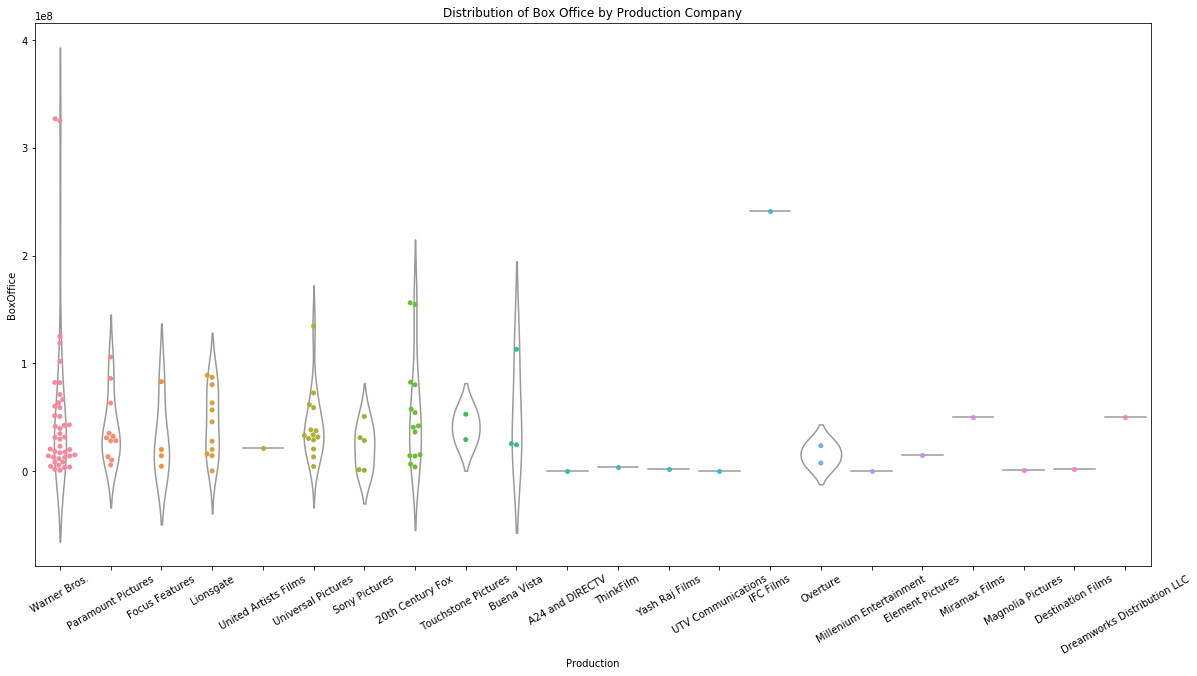

In [33]:
plt.figure(figsize=(20,10))

sns.violinplot(x='Production', y='BoxOffice', data=m_nosub, inner=None, color='w')
sns.swarmplot(x='Production', y='BoxOffice', data=m_nosub)

plt.title("Distribution of Box Office by Production Company")
plt.xticks(rotation=30)

For most companies that produced multiple movies, the range of distribution of box office is very large. For further investigation, we can use a bar plot to display the mean and standard deviation of box office for companies with more than one movie.

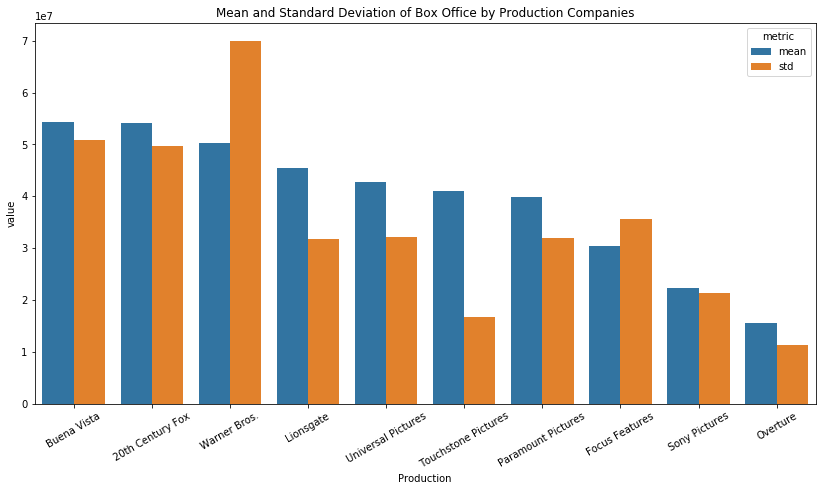

In [34]:
# Reshape the dataframe 
bo_df = pd.melt(bo_df.dropna(), id_vars=['Production'], value_vars=['mean','std'], var_name='metric')

plt.figure(figsize=(14,7))
plt.title('Mean and Standard Deviation of Box Office by Production Companies')
plt.xticks(rotation=30)

sns.barplot(y = 'value',
            x = 'Production',
            hue = 'metric',
            data = bo_df)

The companies that produced more than one movie all have a mean box office of the order of ten millions ($10,000,000). The standard deviation is very large for every company, which might due to small sample size, or different profitability of subsidiary companies.

**Limitations**

- The sample size is too small. There are a lot of missing values in box office. In future analysis, we could look for the values from other sources.
- Inconsistent group of subsidiary/parent company. As stated in Problem 3, it is difficult to decide whether to use parent company only, or a combination of subsidiary/parent company in our analysis.
- Inaccurate box office values. The box office in this dataset for many movies is different from the box office value on IMDB.

**Question 3.** Are movies of a particular genre more successful, or less successful than others?

First of all, we will define 'success' of a movie from two perspectives: the box office (i.e. the popularity) and the imdb rating (i.e. the quality). We will group the movies by genre and rank the genres based on group mean/median.

Notice that the 'Genre' attribute in the original dataset is irregular in the sense that the number of genre tags associated with a movie varies:


In [35]:
movies_df.loc[0:5, ['Title', 'Genre']]

,Title,Genre
0,.45,"Crime, Drama, Thriller"
1,Adventures in Babysitting,"Adventure, Comedy, Crime, Romance"
2,The Adventures of Pluto Nash,"Comedy, Action, Sci-Fi"
3,Against the Ropes,"Biography, Drama, Romance, Sport"
4,Angel Eyes,"Drama, Romance"
5,American Pie Presents: Beta House,Comedy


Since our final goal is to analyze the movies by 'Genre', our first step is to split the list of genre tags into separate rows so that each row is now uniquely identified by the combination of 'Title' and 'Genre' (whose value is now a single word):

In [36]:
# split the long string into a list of strings
genres = movies_df.Genre.str.split(',')

rows= []
for i in range(len(genres)):
    for g in genres[i]:
        # extract only the useful variables from the original df
        other_cols = movies_df.loc[i, ['Title', 'BoxOffice', 'imdbRating']]
        other_cols = other_cols.to_dict()
        
        # separately add each of the genre tags to the corresponding movie
        other_cols['Genre'] = g.strip()
        rows.append(other_cols)

# create a new df with only one word in each cell under 'Genre'
genres = pd.DataFrame(rows)
# drop 'N/A' genre
genres = genres[genres.Genre != 'N/A']
genres = genres[['Title', 'Genre', 'BoxOffice', 'imdbRating']]
genres.head(10)

,Title,Genre,BoxOffice,imdbRating
0,.45,Crime,NaN,5.6
1,.45,Drama,NaN,5.6
2,.45,Thriller,NaN,5.6
3,Adventures in Babysitting,Adventure,NaN,6.9
4,Adventures in Babysitting,Comedy,NaN,6.9
5,Adventures in Babysitting,Crime,NaN,6.9
6,Adventures in Babysitting,Romance,NaN,6.9
7,The Adventures of Pluto Nash,Comedy,4366829.0,3.8
8,The Adventures of Pluto Nash,Action,4366829.0,3.8
9,The Adventures of Pluto Nash,Sci-Fi,4366829.0,3.8


> Here we wrote some useful functions for visualizing the distributions of the three attributes.

In [37]:
def violin_by_genre(col):
    """
    Plots both a violin plot and a swarm plot 
    to show the distribution of col by movie genre.
    """
    plt.figure(figsize=(15,6))
    
    np.warnings.filterwarnings('ignore')
    sns.violinplot(x='Genre', y=col, data=genres, inner=None, color='w')
    sns.swarmplot(x='Genre', y=col, data=genres)
    
    # labels
    plt.ylabel(col)
    plt.title('Distribution of ' + col + ' by Movie Genre')
    plt.xticks(rotation=30)

In [38]:
def rank_by_mean_median(col):
    """
    Groups the global df named 'genres' by 'Genre' and then
    computes and provides a rank of the mean and median of col.
    Sorts the overall df by the rank by median.
    """
    # group by genre
    g = genres.loc[:, ['Genre', col]]
    g = g.groupby('Genre', as_index = False)
    
    # computes mean and median of col
    m1, m2 = col+'_Mean', col+'_Median'
    g = g.agg({col:['mean', 'median']})
    # take care of the multi-index
    g = g.rename(columns={'mean':m1,'median':m2,'':'Genre'}, level=1)
    g.columns = g.columns.droplevel()
    
    # rank and sort
    g['Rank_by_Mean'] = g[m1].rank(ascending = False)
    g['Rank_by_Median'] = g[m2].rank(ascending = False)
    g = g.sort_values('Rank_by_Median', ascending = True)
    return g

In [39]:
def bar_by_mean_median(df, col):
    """
    Plots a barplot of mean and median of col vs. 'Genre' in df.
    Expects df to have attributes named col+'_Mean' and col+'_Median'.
    """
    # Extracts mean
    mean = df.loc[:, ['Genre', col+'_Mean']]
    mean = mean.rename(columns={col+'_Mean':col})
    mean['Metric'] = 'Mean'
    # Extracts median
    median = df.loc[:, ['Genre', col+'_Median']]
    median = median.rename(columns={col+'_Median':col})
    median['Metric'] = 'Median'
    
    # combine
    mm = pd.concat([mean, median], axis=0, sort=False)
    
    # plot
    plt.figure(figsize=(15,6))
    sns.barplot(x='Genre', y=col, hue='Metric', data = mm)
    plt.title('Distribution of Mean and Median of ' + col + ' by Movie Genre')
    plt.xticks(rotation=30)
    

**1) Box Office**

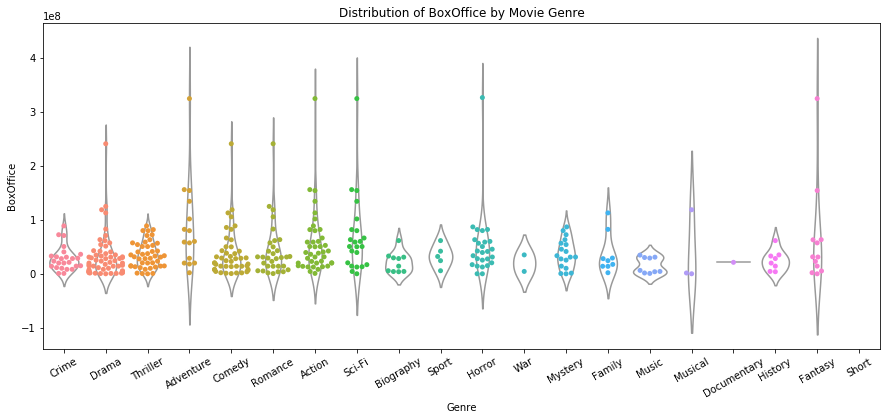

In [40]:
violin_by_genre('BoxOffice')

> From the above graph, we can see that while most movies had a box office of around $30,000,000, the movies that earned the highest revenue were tagged as 'Action', 'Adventure', 'fantasy', 'Horror' and/or 'Sci-Fi'. However, observe that the highest 5 data points have approximately the same height, meaning that some of them could come from the same movie. In fact, by sorting the movies by the box office in a descending order, we found out that the highest 8 data points are from just 3 movies:

In [41]:
movies_df.loc[:, ['Title', 'BoxOffice', 'Genre']].sort_values(by='BoxOffice', ascending=False).head(3)

,Title,BoxOffice,Genre
118,It,326898358.0,Horror
230,Suicide Squad,325021779.0,"Action, Adventure, Fantasy, Sci-Fi"
156,My Big Fat Greek Wedding,241250669.0,"Comedy, Drama, Romance"


> Since many of the distributions are extremely right-skewed, we will compare not only the means, but also the medians to remove the impacts of the outliers.

> The following table shows the rank of the movie genres based on both the mean box office and the median box office. Since we are interested in a more general case, the whole table is ranked by the median. 

In [44]:
bo_rank = rank_by_mean_median('BoxOffice').reset_index(drop=True)
bo_rank.round(2)

,Genre,BoxOffice_Mean,BoxOffice_Median,Rank_by_Mean,Rank_by_Median
0,Adventure,86658144.13,60128566.0,1.0,1.0
1,Sci-Fi,69483667.78,50666882.0,2.0,2.0
2,Horror,51637832.73,40502597.0,5.0,3.0
3,Action,55534772.80,39532308.0,4.0,4.0
4,Mystery,37568317.72,32374298.0,9.0,5.0
5,Thriller,35610035.16,32229420.0,11.0,6.0
6,Sport,33164765.60,32178777.0,12.0,7.0
7,Fantasy,64223979.58,31329845.5,3.0,8.0
8,Romance,42805283.38,30611320.0,6.0,9.0
9,Family,36072536.89,24381334.0,10.0,10.0


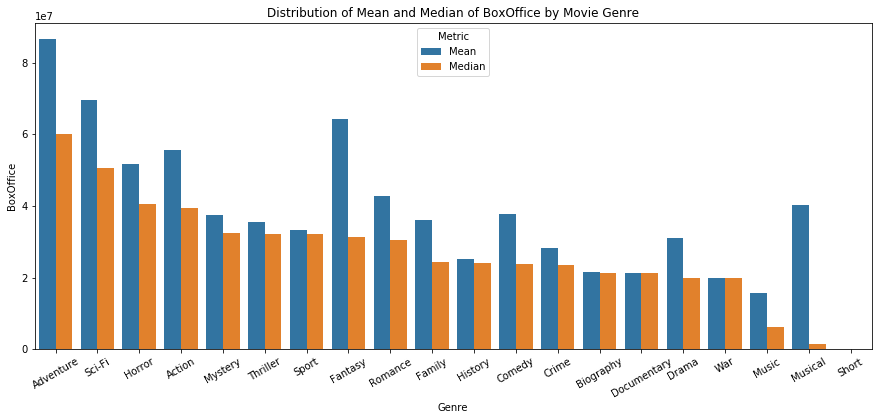

In [45]:
bar_by_mean_median(bo_rank, 'BoxOffice')

>The above barplot clearly shows that from the perspective of earning higher revenue, movies of genre 'Adventure' or 'Sci-Fi' are the most successful. On the otherhand, movies of genre 'Music' or 'Musical' generally earn little revenue. Note that we do not have any data for short movies.

**2) IMDB Rating**

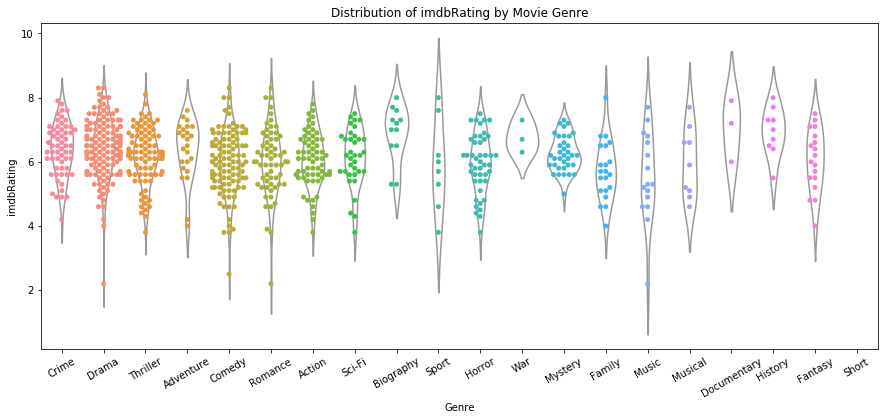

In [46]:
violin_by_genre('imdbRating')

> By looking at the above graph, we found that the distributions of imdb ratings tend to be left-skewed. If we only look at the position of the distributions, the most successful movie genres in terms of receiving the best ratings overall are 'Biography' and 'Documentary'. However, we can see that there is a huge gap in the number of rated movies across different genres. For example, although 'Documentary' movies seem to have a higher average rating than 'Drama' movies, we have to consider the fact that there are only 3 data points in the 'Documentary' category.

> With this limitation in mind, we can now look at the rank by both the mean and the median rating:

In [47]:
rating_rank = rank_by_mean_median('imdbRating').reset_index(drop=True)
rating_rank.round(2)

,Genre,imdbRating_Mean,imdbRating_Median,Rank_by_Mean,Rank_by_Median
0,Documentary,7.03,7.20,1.0,1.0
1,Biography,6.89,7.10,3.0,2.0
2,History,6.93,7.00,2.0,3.0
3,War,6.77,6.70,4.0,4.0
4,Adventure,6.36,6.60,7.0,5.0
5,Crime,6.38,6.50,6.0,6.5
6,Drama,6.41,6.50,5.0,6.5
7,Thriller,6.19,6.20,9.0,9.0
8,Mystery,6.25,6.20,8.0,9.0
9,Sci-Fi,6.14,6.20,10.0,9.0


> From the above table, it is clear that the most successful movie genres with this definition are 'Documentary', 'Biography' and 'History'. By comparing with the previous graph, we can see that these genres have very few data points. Surprisingly, the genres with the worst ratings are not the ones with the most data points. Popular movie genres such as 'Drama', 'Thriller' and 'Crime' are in the middle of the rank; whereas 'Family' and 'Music' movies are the least successful overall.

> The following bar plot provides a more straight-forward visualization of the rank. We can see that there is not too much difference between the actual ratings, especially among those in the middle of the rank.

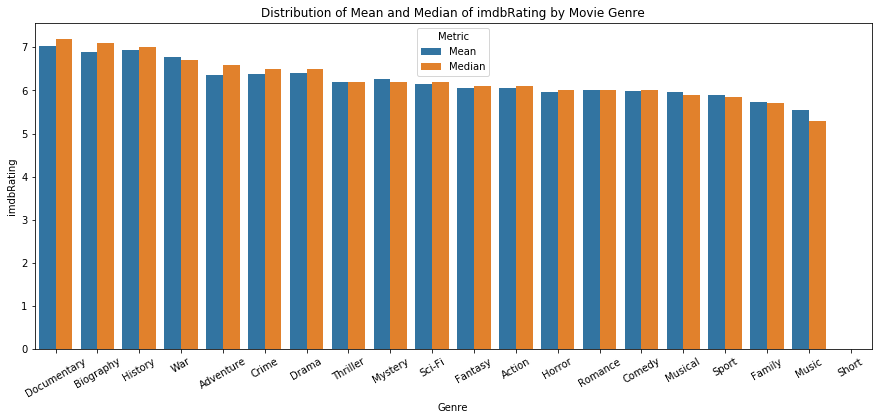

In [48]:
bar_by_mean_median(rating_rank, 'imdbRating')

**3) Overall**

In [49]:
# rename the two rank dfs
b = bo_rank[['Genre', 'Rank_by_Median']].rename(columns={'Rank_by_Median':'Rank_BoxOffice'})
r = rating_rank[['Genre', 'Rank_by_Median']].rename(columns={'Rank_by_Median':'Rank_Rating'})

# combine them and compute an average rank
combined = b.sort_values('Genre').merge(r.sort_values('Genre'))
combined['Rank_Avg'] = 1/2 * (combined['Rank_BoxOffice'] + combined['Rank_Rating'])

# sort by the rank avg
combined.sort_values('Rank_Avg').reset_index(drop=True)

,Genre,Rank_BoxOffice,Rank_Rating,Rank_Avg
0,Adventure,1.0,5.0,3.00
1,Sci-Fi,2.0,9.0,5.50
2,History,11.0,3.0,7.00
3,Mystery,5.0,9.0,7.00
4,Thriller,6.0,9.0,7.50
5,Action,4.0,11.5,7.75
6,Biography,14.0,2.0,8.00
7,Documentary,15.0,1.0,8.00
8,Horror,3.0,14.0,8.50
9,Fantasy,8.0,11.5,9.75


> In conclusion, we looked at the most successful movie genres from two perspectives: the box office for profitability / popularity and the imdb rating for quality. By taking an average of the two ranks, we found out that 'Adventure' and 'Sci-Fi' movies tend to be the most successful whereas 'Musical' and 'Music' movies tend to be the least successful.

> Finally, note that there are a few limitations on our analysis. For example, there is no data for 'Short' movies and also very little data for genres including 'Documentary' and 'War'. Also, we could have defined 'success' based on other attributes such as 'imdbVotes' and 'Awards'. However, we do not have data for the actual names of the awards nor their significance, thus we did not choose this definition.

 <br>
 <br>
 
 # <p style="background-color: #EEEEEE;text-align:center;padding-top: 15px;padding-bottom: 15px;" >Submission and Grading </p>
 
## Submission

**What should be submitted?**

* A Jupyter notebook using Python that contains all the data analyses. The flow of the notebook should be Markdown and Code cells weaved together. In addition make sure to comment your code in the code cells.

* Additional files that your notebook requires to compile properly (e.g. a data file).

* A report from your Jupyter notebook exported as a html file without the code cells. This can be done using [nbconvert](https://nbconvert.readthedocs.io/en/latest/).

**When should it be submitted?**
* At the end of the lab session (in-lab progress): Submit your current progress, i.e., <mark><b>before 2:30pm on the day of the laboratory, January 15.</b></mark> (Submit to Github Classroom, and Quercus: "L2.1. In-lab progress")
* Homework (lab assignment completion): Upload your completed lab assignment by the next class, on <mark><b>Monday January 20 at 12:00pm (noon)</b></mark>. (Submit to Github Classroom, and Quercus: "L2.1. Lab Assignment Completed")

**Where should the assignment be submitted?**
* Commit your finished notebook (ipynb and html versions), and any other files on the Github Classroom repository.
* Submit a pdf version of this notebook, including code cells (print this notebook to pdf) to Quercus.


## Grading

Laboratory 2.1. will be graded according to the following marking scheme.

| | Marks|
|--- |--- |
| In-lab progress | 5 |
| Lab assignment completion | 10 |
| Attendance for entire lab | 5 |
| **Total** | **20**|


Note that marks will be deduced for the following reasons: notebook doesn't compile; files are missingl; instructions are not followed.


### In-lab progress grading rubric

In-lab progress rubric is as follows (also available [here](https://jsc270.github.io/tut_grading.html#in-lab_progress)):

|Category|5|4|3|2|1|
|---|:---:|:---:|:---:|:---:|:---:|
|**Progress (5 pts)** | Excellent progress. Optimal use of lab time. The team was fully focused on getting the assignment done, and fully engaged. Excellent progress. | Good progress. Good use of lab time. The team was focused on getting the assignment done, and engaged. | Moderate progress. Used some of the lab time well. There was some focus on getting the assignment done, but the team was occasionnally distracted. | Insufficient progress. Poor use of lab time. The team was generally distracted, and did not focus much on the assignment. | Minimal progress. The team did barely use lab time to make progress on the assignment, and was often distracted. |

<br>

### Lab assignment completion grading rubric

Lab assignment completion grading rubric is as follows (also available [here](https://jsc270.github.io/tut_grading.html#lab_assignment_completion)):

|Category|5|4|3|2|1|
|---|:---:|:---:|:---:|:---:|:---:|
|**Planning of code and statistical analysis <br> (2.5 pts)** | Introductory comment describes overall strategy and gives evidence of preliminary planning. Thoughtful problem decomposition breaks the problem into independent pieces that can be solved easily. | Evidence of planning before coding, but some flaws in overall strategy. | More planning needed: overall strategy ok, but have missed some obvious ways of making the code simpler. | It all hangs together, but planning was absent or rushed. | No evidence of planning. Strategy deeply flawed.|
|**Programming execution and reproducibility of results <br> (2.5 pts)**| Mastery of Python vocabulary means that the absolute minimum amount of code is used to get the job done. Code free from duplication. Each function encapsulates a single task, and repeated tasks are performed by functions, not copy and paste. | Workable, but not elegant.  Common programming idioms used to reduce code. | The code works, but copy-paste used often. | Most of the code works, but some parts do not work. Copy-paste used very often. | Functions used inapproriately, or existing functions reinvented. Extensive use of copy and paste. |
|**Programming Clarity <br> (2.5 pts)** | Code is a pleasure to read, and easy to understand. Code and comments form part of a seamless whole. | Comments used to discuss the why, and not how of code; to provide insight into complicated algorithms; and to indicate purpose of function (if not obvious from its name). Comment headings used to separate important sections of the code. | Generally easy to read, but some comments used inappropriately: either too many, or too few. Some variable names confusing. | Hard to understand. Poor choice of names and comments do not generally aid understanding. | Cannot understand code. The reader cannot understand why the code works. |
|**Communication <br>(2.5 pts)**| Findings very well organised. Clear headings demarcate separate sections. Excellent flow from one section to the next. The report is easy to scan.  Tables and graphics carefully tuned and placed for desired purpose. | Findings well organised and sections clearly separated, but flow is lacking. Each section has clear purpose.  Tables and graphics clear and well chosen. | Generally well organised, but some sections muddled.  Tables or graphics appropriate, but some are poorly presented - e.g. too many decimal places, poorly chosen aspect ratio etc. | Sections unclear and no attempt to flow from one topic to the next. Graphics and tables poorly chosen to support questions. Some have fundamental flaws. | It is hard to read your notebook. There are no headings, figures are far away from where they are referenced in the text. There is no summary or conclusion. |